In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn
import os
from datetime import datetime, timedelta
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input, TimeDistributed, LeakyReLU, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,TensorBoard

/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
os.listdir('./data/')

['DJI_ema.csv',
 'DJI_STO_20period_sma10.csv',
 'DJI_modified_sma.csv',
 '.DS_Store',
 'DJI_modified_features - DJI.csv',
 'DJI_fe.csv',
 'N225withoutNULL.csv',
 'dowjone1985_2019.csv',
 'N225fillVOL.csv',
 'test_djia.csv',
 'DJI_denoise.csv',
 'N225.csv',
 'stocknews',
 'preprocessed',
 'downjone5y.csv']

In [3]:
df_nikkei = pd.read_csv('./data/N225withoutNULL.csv')
df_djia = pd.read_csv('./data/DJI_modified_sma.csv')

In [4]:
df_nikkei.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0
3,1985-02-01,11946.959961,11946.959961,11946.959961,11946.959961,11946.959961,0
4,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0


In [5]:
df_djia['Date'][0]

'1985-01-29'

# Preprocess

In [6]:
# postpone 1 day and concatenate both table

# decrement datetime of djia first
df_djia_dc = df_djia.copy()
# df_djia_dc['Date'] = df_djia['Date'] + timedelta(days=-1)
for i in tqdm(range(len(df_djia))):
    df_djia_dc['Date'][i] = str((datetime.strptime(df_djia.iloc[i]['Date'], '%Y-%m-%d') + timedelta(days=-1)).date())

# df_djia_dc.head()
df = pd.merge(df_nikkei, df_djia_dc, on='Date', how='inner')
df = df.rename({'Open_x': 'Open(Nikkei)', 'High_x': 'High(Nikkei)', 'Low_x': 'Low(Nikkei)', 'Close_x': 'Close(Nikkei)',
                'Open_y': 'Open(DJIA)', 'High_y': 'High(DJIA)', 'Low_y': 'Low(DJIA)', 'Close_y': 'Close(DJIA)'
               }, axis=1)


  0%|          | 0/8762 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 8762/8762 [00:02<00:00, 3720.26it/s]


In [7]:
df.head()

,Date,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Adj Close_x,Volume_x,Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA),Adj Close_y,Volume_y,sma5,sma10,sma25,sma75,sma125,sma200
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971
3,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0,1294.060059,1301.130005,1278.599976,1285.229980,1285.229980,13800000,1285.535986,1285.229980,1285.229980,1285.229980,1285.229980,1285.229980
4,1985-02-05,11823.429688,11823.429688,11823.429688,11823.429688,11823.429688,0,1284.890015,1294.500000,1275.069946,1280.589966,1280.589966,14610000,1284.077979,1280.589966,1280.589966,1280.589966,1280.589966,1280.589966


In [8]:
event_col = ['Open(Nikkei)', 'High(Nikkei)', 'Low(Nikkei)', 'Close(Nikkei)',
            'Open(DJIA)', 'High(DJIA)', 'Low(DJIA)', 'Close(DJIA)'
            ]
total_col = df.columns
for col in total_col:
    if col not in event_col:
        df = df.drop(col, axis=1)

In [9]:
df.tail()

,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA)
6906,22619.769531,22648.810547,22457.890625,22625.380859,26893.92969,26931.77930,26714.33984,26805.52930
6907,22725.439453,22780.990234,22704.330078,22750.599609,26789.60938,27015.36914,26765.67969,26958.06055
6908,22854.439453,22896.220703,22830.570313,22867.269531,27061.07031,27165.93945,27039.75977,27071.46094
6909,22950.789063,23008.429688,22935.349609,22974.130859,27110.71094,27204.35938,26999.64063,27186.68945
6910,22953.169922,22961.230469,22827.929688,22843.119141,27188.36914,27188.36914,26918.28906,27046.23047


In [10]:
def normalize_data(df, event_col):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    for col in event_col:
        if col != 'Date':
            df[col] = min_max_scaler.fit_transform(df[col].to_numpy().reshape(-1, 1))
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]
    

In [11]:
# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_norm = normalize_data(df, event_col)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (5513, 19, 8)
y_train.shape =  (5513, 8)
x_val.shape =  (689, 19, 8)
y_val.shape =  (689, 8)
x_test.shape =  (689, 19, 8)
y_test.shape =  (689, 8)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


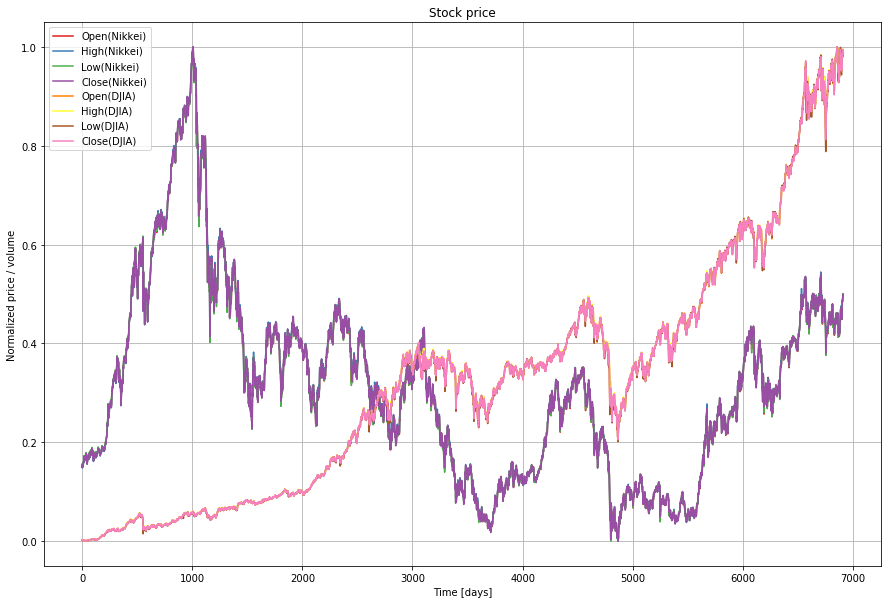

In [12]:
# plot graph before train

# !set color in graph
# color_palette = ...
plt.figure(figsize=(15, 10))
plt.grid()
color_palette = plt.get_cmap('Set1')
for i, col in enumerate(event_col):
    plt.plot(df_norm[col], color=color_palette(i), label=col)
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend()
plt.show()

In [13]:
start = 0
for i in range(df.shape[0]) :
    if df.loc[i]['Close(DJIA)'] >= df.loc[i]['Close(Nikkei)'] :
        start = i
        break
print(start)
df_2 = df[start:]
df_2

2638


,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA)
2638,0.258003,0.256758,0.237947,0.243070,0.252139,0.251625,0.248385,0.247049
2639,0.258003,0.256758,0.237947,0.243070,0.247315,0.248459,0.247263,0.245836
2640,0.247327,0.270863,0.249590,0.258785,0.246054,0.247600,0.247225,0.246570
2641,0.243875,0.243346,0.235396,0.242311,0.251280,0.255440,0.252319,0.255637
2642,0.244138,0.256102,0.246399,0.257487,0.255874,0.256852,0.255978,0.255342
...,...,...,...,...,...,...,...,...
6906,0.488358,0.488062,0.485756,0.488699,0.983626,0.983267,0.980601,0.979176
6907,0.491674,0.492212,0.493498,0.492630,0.979626,0.986467,0.982577,0.985018
6908,0.495723,0.495829,0.497464,0.496292,0.990036,0.992232,0.993125,0.989362
6909,0.498747,0.499351,0.500755,0.499646,0.991939,0.993703,0.991581,0.993776


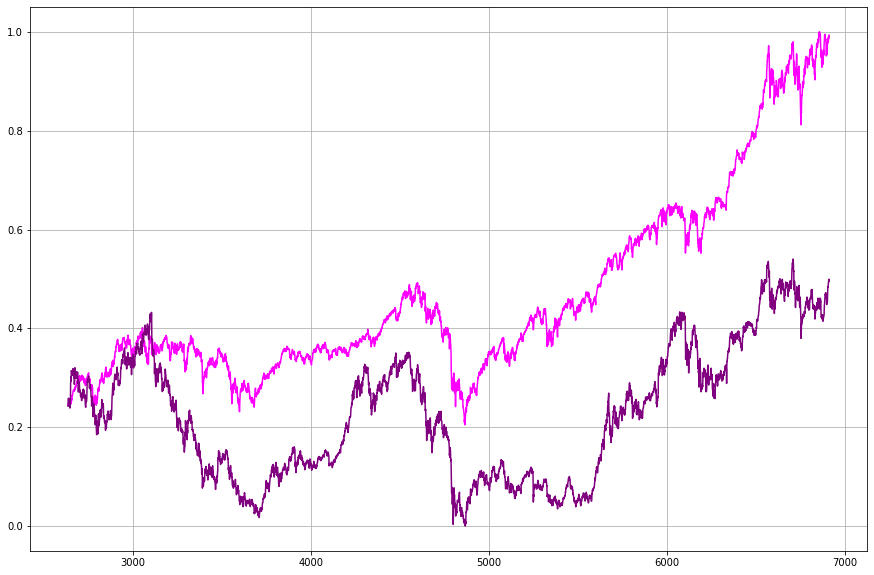

In [14]:
# plot graph after 2 graph sync

# !set color in graph
# color_palette = ...
plt.figure(figsize=(15, 10))
plt.grid()
color_palette = plt.get_cmap('Set1')
plt.plot(df_2['Close(DJIA)'],color='magenta')
plt.plot(df_2['Close(Nikkei)'],color='purple')

In [15]:
# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_2_norm = normalize_data(df_2, event_col)

# split train, val, test data

x2_train, y2_train, x2_val, y2_val, x2_test, y2_test = load_data(df_2_norm, seq_len)

print('x_train.shape = ', x2_train.shape)
print('y_train.shape = ', y2_train.shape)
print('x_val.shape = ', x2_val.shape)
print('y_val.shape = ', y2_val.shape)
print('x_test.shape = ', x2_test.shape)
print('y_test.shape = ', y2_test.shape)

x_train.shape =  (3403, 19, 8)
y_train.shape =  (3403, 8)
x_val.shape =  (425, 19, 8)
y_val.shape =  (425, 8)
x_test.shape =  (425, 19, 8)
y_test.shape =  (425, 8)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [16]:
df_2_norm

,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA)
2638,0.474720,0.471511,0.439808,0.449848,0.061221,0.051805,0.058767,0.052873
2639,0.474720,0.471511,0.439808,0.449848,0.055165,0.047793,0.057362,0.051347
2640,0.455077,0.497415,0.461328,0.478932,0.053581,0.046705,0.057315,0.052270
2641,0.448725,0.446881,0.435092,0.448443,0.060142,0.056639,0.063694,0.063675
2642,0.449209,0.470308,0.455429,0.476530,0.065909,0.058427,0.068276,0.063304
...,...,...,...,...,...,...,...,...
6906,0.898570,0.896280,0.897844,0.904434,0.979446,0.978799,0.975707,0.973806
6907,0.904672,0.903900,0.912153,0.911707,0.974425,0.982854,0.978181,0.981155
6908,0.912122,0.910542,0.919483,0.918484,0.987492,0.990158,0.991391,0.986619
6909,0.917686,0.917011,0.925567,0.924691,0.989882,0.992022,0.989458,0.992170


# Training

In [17]:
# hyperparameter 
batch_size = 1024
epochs = 300

# set up callback_list
weight_path_model = "saved_model/model_djia_support_nikkei_sync_period.h5"
tensorboard_path = 'Graph/djia_support_nikkei_sync_period'
callbacks_list_model = [
    TensorBoard(log_dir=tensorboard_path),
    ModelCheckpoint(
            weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, min_lr=1e-9)
]

In [18]:
K.clear_session()

def get_bi_gru():
    
    input1 = Input(shape=(19,8,))
    x = Bidirectional(LSTM(256, return_sequences=True,  kernel_initializer='Orthogonal'))(input1)
    x = TimeDistributed(LeakyReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = GRU(128,kernel_initializer='Orthogonal')(x)
    x =(LeakyReLU())(x)
    x = (BatchNormalization())(x)
    x = (Dropout(0.25))(x)
    out = Dense(8,kernel_initializer='he_normal')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(lr=1e-2, decay=1e-2),
                loss='mse',
                metrics=['mse'])   
    
    return model

model = get_bi_gru()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 8)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 19, 512)           542720    
_________________________________________________________________
time_distributed (TimeDistri (None, 19, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 512)           2048      
_________________________________________________________________
gru (GRU)                    (None, 128)               246144    
_______________________

# Experiment and Result

In [19]:
history = model.fit(x2_train, y2_train, epochs=epochs , callbacks=callbacks_list_model,
          validation_data=(x2_val, y2_val),batch_size=batch_size) 

Train on 3403 samples, validate on 425 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
3072/3403 [==========================>...] - ETA: 0s - loss: 4.6073 - mean_squared_error: 4.6073
Epoch 00001: val_loss improved from inf to 0.64364, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 4s 1ms/sample - loss: 4.2515 - mean_squared_error: 4.2515 - val_loss: 0.6436 - val_mean_squared_error: 0.6436
Epoch 2/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.3448 - mean_squared_error: 0.3448
Epoch 00002: val_loss improved from 0.64364 to 0.58506, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 804us/sample - loss: 0.3247 - mean_squared_error: 0.3247 - val_loss: 0.5851 - val_mean_squared_error: 0.5851
Epoch 3/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0621 - m

Epoch 25/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 00025: val_loss improved from 0.56431 to 0.54730, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 958us/sample - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.5473 - val_mean_squared_error: 0.5473
Epoch 26/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 00026: val_loss did not improve from 0.54730
3403/3403 [==============================] - 3s 951us/sample - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.5477 - val_mean_squared_error: 0.5477
Epoch 27/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 00027: val_loss did not improve from 0.54730
3403/3403 [==============================] - 3s 945us/sample - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.5722 - val

3072/3403 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 00049: val_loss improved from 0.42763 to 0.42279, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 922us/sample - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.4228 - val_mean_squared_error: 0.4228
Epoch 50/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 00050: val_loss improved from 0.42279 to 0.41800, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 920us/sample - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.4180 - val_mean_squared_error: 0.4180
Epoch 51/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 00051: val_loss improved from 0.41800 to 0.41276, saving model to saved_model/model_djia_support_nikkei_sync_peri

Epoch 70/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 00070: val_loss improved from 0.18545 to 0.17375, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 940us/sample - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.1738 - val_mean_squared_error: 0.1738
Epoch 71/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 00071: val_loss improved from 0.17375 to 0.16175, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 968us/sample - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.1617 - val_mean_squared_error: 0.1617
Epoch 72/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 00072: val_loss improved from 0.16175 to 0.15321, saving model to saved_model/model_djia_support_nik

Epoch 92/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 00092: val_loss improved from 0.10964 to 0.10876, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 969us/sample - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.1088 - val_mean_squared_error: 0.1088
Epoch 93/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 00093: val_loss improved from 0.10876 to 0.10860, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 958us/sample - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.1086 - val_mean_squared_error: 0.1086
Epoch 94/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 00094: val_loss improved from 0.10860 to 0.10764, saving model to saved_model/model_djia_support_nik

Epoch 113/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 00113: val_loss did not improve from 0.09121
3403/3403 [==============================] - 3s 922us/sample - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0915 - val_mean_squared_error: 0.0915
Epoch 114/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 00114: val_loss improved from 0.09121 to 0.08912, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 969us/sample - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0891 - val_mean_squared_error: 0.0891
Epoch 115/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 00115: val_loss improved from 0.08912 to 0.08868, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 948u

Epoch 135/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 00135: val_loss did not improve from 0.06615
3403/3403 [==============================] - 3s 949us/sample - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0663 - val_mean_squared_error: 0.0663
Epoch 136/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 00136: val_loss improved from 0.06615 to 0.06439, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 959us/sample - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0644 - val_mean_squared_error: 0.0644
Epoch 137/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 00137: val_loss improved from 0.06439 to 0.06133, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 961u

Epoch 157/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 00157: val_loss improved from 0.03634 to 0.03454, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 964us/sample - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 158/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 00158: val_loss improved from 0.03454 to 0.03388, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 967us/sample - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 159/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 00159: val_loss improved from 0.03388 to 0.03304, saving model to saved_model/model_djia_support_

3072/3403 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 00179: val_loss improved from 0.01581 to 0.01536, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 972us/sample - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0154 - val_mean_squared_error: 0.0154
Epoch 180/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 00180: val_loss did not improve from 0.01536
3403/3403 [==============================] - 3s 967us/sample - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 181/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 00181: val_loss did not improve from 0.01536
3403/3403 [==============================] - 3s 934us/sample - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0163 - val_mean_squar

Epoch 201/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 00201: val_loss did not improve from 0.00686
3403/3403 [==============================] - 3s 964us/sample - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 202/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 00202: val_loss did not improve from 0.00686
3403/3403 [==============================] - 3s 945us/sample - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 203/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 00203: val_loss did not improve from 0.00686
3403/3403 [==============================] - 3s 1ms/sample - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 204/300
3072/3403 [====================

3072/3403 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 00224: val_loss did not improve from 0.00378
3403/3403 [==============================] - 3s 929us/sample - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 225/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 00225: val_loss did not improve from 0.00378
3403/3403 [==============================] - 3s 934us/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 226/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 00226: val_loss did not improve from 0.00378
3403/3403 [==============================] - 3s 936us/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 227/300
3072/3403 [==========================>...] 

Epoch 247/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 00247: val_loss did not improve from 0.00216
3403/3403 [==============================] - 3s 924us/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 248/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 00248: val_loss improved from 0.00216 to 0.00211, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 958us/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 249/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 00249: val_loss improved from 0.00211 to 0.00204, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 935u

Epoch 271/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 00271: val_loss improved from 0.00170 to 0.00163, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 979us/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 272/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 00272: val_loss improved from 0.00163 to 0.00159, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
3403/3403 [==============================] - 3s 1ms/sample - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 273/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 00273: val_loss improved from 0.00159 to 0.00154, saving model to saved_model/model_djia_support_ni

Epoch 295/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 00295: val_loss did not improve from 0.00142
3403/3403 [==============================] - 3s 999us/sample - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 296/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 00296: val_loss did not improve from 0.00142
3403/3403 [==============================] - 3s 944us/sample - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 297/300
3072/3403 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 00297: val_loss did not improve from 0.00142
3403/3403 [==============================] - 3s 939us/sample - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 298/300
3072/3403 [==================

In [20]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])


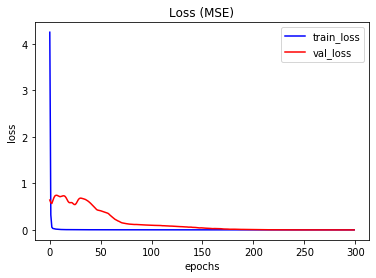

In [21]:
plt.title("Loss (MSE)")
plt.plot(history.history['loss'],color = 'blue',label="train_loss")
plt.plot(history.history['val_loss'],color = 'red',label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig('loss_support_sync_data.png')

In [22]:
y2_train_pred = model.predict(x2_train)
y2_val_pred = model.predict(x2_val)
y2_test_pred = model.predict(x2_test)

In [23]:
#fix!
def plot_compare(x, event_col):
#     Col = {'Open':0, 'High':1, 'Low':2, 'Close':3}
    Col = dict()
    count = 0
    for i, col in enumerate(event_col):
        Col[col] = i
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y2_train.shape[0]), y2_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y2_train.shape[0], y2_train.shape[0] + y2_val.shape[0]), y2_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y2_train.shape[0] + y2_val.shape[0], y2_train.shape[0] + y2_val.shape[0] + y2_test.shape[0]),
            y2_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y2_train_pred.shape[0]), y2_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y2_train_pred.shape[0], y2_train_pred.shape[0] + y2_val_pred.shape[0]),
            y2_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y2_train_pred.shape[0] + y2_val_pred.shape[0],
            y2_train_pred.shape[0] + y2_val_pred.shape[0] + y2_test_pred.shape[0]),
            y2_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price :' + x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y2_train.shape[0], y2_train.shape[0] + y2_test.shape[0]),
            y2_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y2_train.shape[0], y2_train.shape[0] + y2_test_pred.shape[0]),
            y2_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices :' + x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')



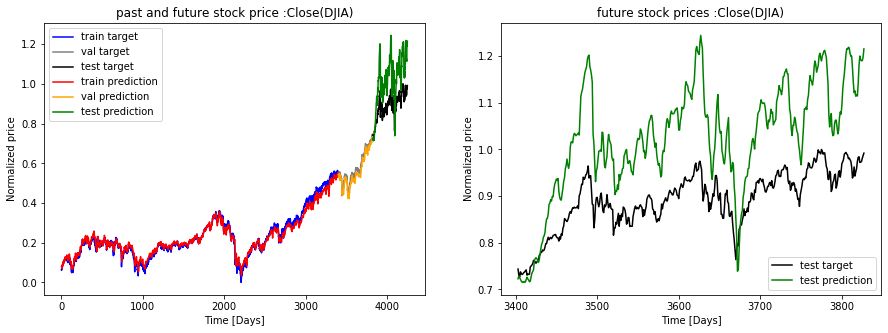

In [24]:
plot_compare('Close(DJIA)', event_col)